In [10]:
from yoloface.face_detector import YoloDetector
from PIL import Image
import numpy as np
import glob
import pandas as pd
from util.distance import findEuclideanDistance
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def get_all_images(video_name):
    """
    dataset 폴더 안에 있는 모든 이미지 경로를 반환하는 함수입니다.
    """
    images = []
    frames = glob.glob(f'./dataset/{video_name}/frame/*')
    for frame in frames:
        for image in glob.glob(frame + '/*.jpg'):
            images.append(image)
    return images

def sort_by_x1(boxes):
    """
    감지한 boundary box list 를 x1이 작은 순서대로 (왼쪽부터) 정렬하는 함수입니다.
    """
    boxes = sorted(boxes, key = lambda x : x[0][0])
    return boxes

def zip_person(boxes, points):
    """
    box 와 landmark 의 리스트를 각 사람의 box 와 landmark 로 합치는 함수입니다.
    """
    person = zip(boxes[0], points[0])
    return list(person)

def make_df_detection_by_detector(detector, video_name):
    """
    Face Detection 데이터 프레임을 만드는 함수입니다.
    :param: detector ['opencv', 'ssd', 'mtcnn', 'retinaface', 'yoloface]
    :return:
    """
    df_detection = pd.DataFrame(columns=['frame_num', 'video_num', 'detect_person_num', 'boxes', 'landmarks'])
    images = get_all_images(video_name)
    if detector == 'yoloface':
        yolo_detector = YoloDetector(target_size=720, gpu=-1, min_face=90)
        for image in images:
            # 영상 번호
            video_num = image.split('/')[-1][:-4]  # [:-4] -> .jpg remove
            # frame 번호
            frame_num = image.split('/')[-2]
            # 이미지 경로 -> ndarray
            image = np.array(Image.open(image))
            # get boundary box and landmarks
            boxes, points = yolo_detector.predict(image)
            # 감지된 사람 중 왼쪽에 있는 사람 순(x1이 작은 순)으로 정렬
            people = sort_by_x1(zip_person(boxes, points))
            # 1명 이상인 경우 / 1명만 검출하고 싶으면 == 1 로 변경
            if len(people) > 0 :
                data = {
                    'frame_num' : int(frame_num),
                    'video_num': int(video_num),
                    'detect_person_num': len(people),
                    'boxes': [person[0] for person in people],
                    'landmarks': [person[1] for person in people]
                }
                df_detection = df_detection.append(data, ignore_index=True)
                print(f'{frame_num}번 째 frame : {video_num} 영상 이미지 저장')
    else:
        print('아직 미구현, Deepface Detector 는 얼굴을 추출하기 때문에 customizing 필요합니다')
    # frame_num 순으로 정렬
    df_detection = df_detection.sort_values(by='frame_num')
    # filter 된 dataframe
    df_filtered = filter_df(df_detection)
    # 데이터프레임 저장
    df_filtered.to_parquet(f'./dataset/{video_name}/detection_data/yoloface_data.parquet')

    return df_filtered

def filter_df(df):
    """
    얼굴을 감지한 데이터프레임에서 감지된 사람 수가 같은 데이터만 추출하여 데이터프레임을 만듭니다.
    """
    # 같은 프레임의 이미지들 중에서 적어도 2번 이상 사람이 감지된 프레임만 추출
    frame_index = df['frame_num'].value_counts()[df['frame_num'].value_counts()>1].index
    # 'frame_num' index 설정
    df = df.set_index('frame_num')

    # 빈 df_filtered 생성
    df_filtered = pd.DataFrame(
        columns=['frame_num', 'video_num', 'detect_person_num', 'boxes', 'landmarks']
    ).set_index('frame_num')

    for frame_num in frame_index:
        df1 = df.loc[frame_num]
        mask = df1.loc[frame_num].duplicated(['detect_person_num'], keep=False)
        df_filtered = pd.concat([df_filtered, df1.loc[mask]])
    return df_filtered

def find_similarity_images(df_filtered):
    similarity_list = []
    for frame in df_filtered.index.unique():
        df_temp = df_filtered.loc[frame]
        # 감지된 사람 수
        detect_person_num = df_temp['detect_person_num'].iloc[0]
        # 영상 번호 리스트
        video_num_list = list(df_temp['video_num'])
        # 선택된 영상 번호
        selected_video = None
        # 거리
        dis_min = 100000000

        for selected_video_nums in list(combinations(video_num_list, 2)):
            videonum1, videonum2 = selected_video_nums[0], selected_video_nums[1]
            landmarks = list(
                df_temp.loc[(df_temp['video_num'] == videonum1) | (df_temp['video_num'] == videonum2)]['landmarks'])
            dis = findEuclideanDistance(landmarks[0], landmarks[1], detect_person_num)
            if dis < dis_min:
                dis_min = dis
                selected_video = selected_video_nums
        similarity_list.append((frame, selected_video, dis_min))
    similarity_list = sorted(similarity_list, key=lambda x: x[2])
    return similarity_list


In [12]:
df = make_df_detection_by_detector('yoloface', 'iu_lilac')
similarity_list = find_similarity_images(df)

-1
/Users/jungsuplim/Desktop/2022_HAI/2022HAISecondSemester/Cross-cutting-with-face/yoloface/weights/yolov5n_state_dict.pt
59번 째 frame : 1 영상 이미지 저장
66번 째 frame : 0 영상 이미지 저장
68번 째 frame : 2 영상 이미지 저장
68번 째 frame : 1 영상 이미지 저장
57번 째 frame : 2 영상 이미지 저장
57번 째 frame : 0 영상 이미지 저장
32번 째 frame : 0 영상 이미지 저장
35번 째 frame : 2 영상 이미지 저장
35번 째 frame : 1 영상 이미지 저장
35번 째 frame : 0 영상 이미지 저장
69번 째 frame : 2 영상 이미지 저장
69번 째 frame : 1 영상 이미지 저장
69번 째 frame : 0 영상 이미지 저장
56번 째 frame : 1 영상 이미지 저장
56번 째 frame : 0 영상 이미지 저장
51번 째 frame : 2 영상 이미지 저장
51번 째 frame : 1 영상 이미지 저장
51번 째 frame : 0 영상 이미지 저장
58번 째 frame : 0 영상 이미지 저장
67번 째 frame : 2 영상 이미지 저장
67번 째 frame : 1 영상 이미지 저장
67번 째 frame : 0 영상 이미지 저장
60번 째 frame : 2 영상 이미지 저장
34번 째 frame : 1 영상 이미지 저장
33번 째 frame : 2 영상 이미지 저장
33번 째 frame : 1 영상 이미지 저장
33번 째 frame : 0 영상 이미지 저장
20번 째 frame : 2 영상 이미지 저장
20번 째 frame : 1 영상 이미지 저장
18번 째 frame : 2 영상 이미지 저장
18번 째 frame : 1 영상 이미지 저장
18번 째 frame : 0 영상 이미지 저장
27번 째 frame : 1 영상 이미지 저장
27번 째 frame : 0 영상 

In [49]:
print(similarity_list)

[(21, (1, 0), 23.130067012440755), (52, (2, 0), 55.00909015790027), (1, (2, 0), 94.83142938920619), (18, (2, 1), 182.15408617736554), (24, (1, 0), 185.88616588295824), (44, (2, 0), 193.1516387596946), (72, (1, 0), 210.45427056726598), (33, (0, 1), 215.10927455598002), (43, (2, 0), 265.5545560185745), (73, (1, 2), 271.1825953117198), (9, (1, 0), 279.1996497928399), (26, (1, 0), 311.29407318482635), (7, (2, 1), 337.5628336571825), (35, (2, 1), 388.4002803523419), (57, (0, 2), 400.347349185679), (67, (1, 0), 402.1942938431623), (47, (1, 2), 462.73588579231676), (55, (2, 1), 469.0319818519842), (27, (1, 0), 669.2841324878395), (69, (0, 2), 674.4466250193561), (12, (0, 2), 836.6265594636594), (42, (0, 2), 1280.4991214366373)]


In [50]:
df

,video_num,detect_person_num,boxes,landmarks
frame_num,,,,
1,2,1,"[[465, 146, 714, 481]]","[[[591, 283], [678, 280], [672, 346], [608, 40..."
1,0,1,"[[472, 113, 790, 522]]","[[[615, 275], [735, 271], [709, 358], [629, 41..."
18,2,3,"[[0, 195, 79, 331], [602, 135, 722, 286], [116...","[[[0, 248], [36, 242], [10, 276], [7, 300], [3..."
18,1,3,"[[97, 314, 190, 423], [605, 237, 689, 350], [1...","[[[120, 354], [157, 353], [134, 373], [123, 39..."
72,1,1,"[[314, 6, 682, 478]]","[[[494, 195], [621, 187], [618, 272], [532, 36..."
72,0,1,"[[309, 94, 680, 588]]","[[[473, 290], [609, 273], [599, 363], [520, 46..."
69,0,2,"[[117, 201, 298, 421], [604, 119, 790, 347]]","[[[152, 308], [217, 284], [184, 335], [187, 37..."
69,2,2,"[[585, 97, 749, 305], [866, 390, 966, 562]]","[[[651, 172], [719, 179], [696, 215], [650, 24..."
67,1,2,"[[176, 206, 343, 460], [506, 139, 727, 435]]","[[[219, 318], [225, 323], [191, 372], [229, 40..."


/var/folders/f1/8sqqkq8j0dz3jtkx0lnjdy080000gn/T/ipykernel_21069/1795072325.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/f1/8sqqkq8j0dz3jtkx0lnjdy080000gn/T/ipykernel_21069/1795072325.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


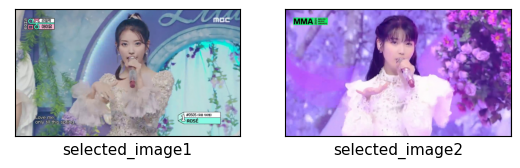

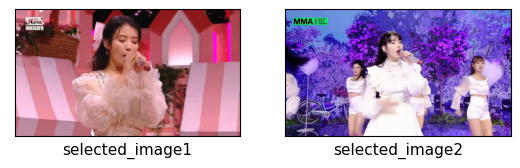

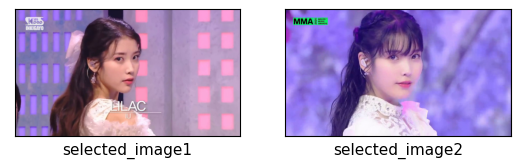

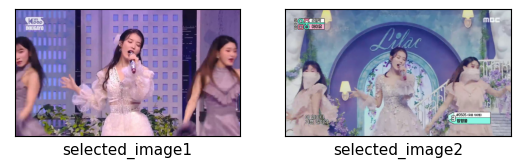

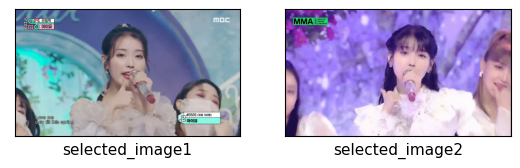

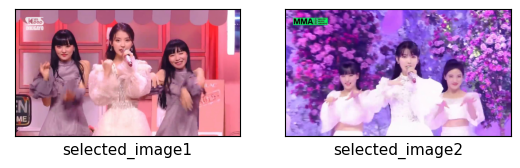

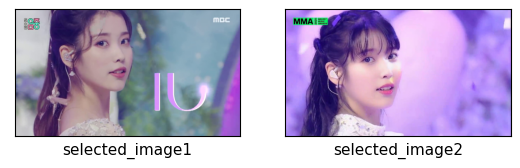

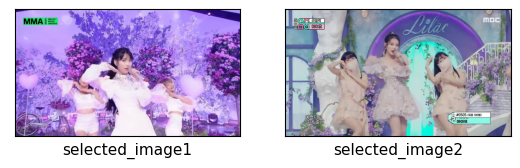

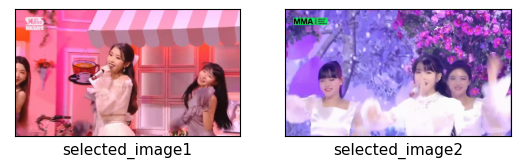

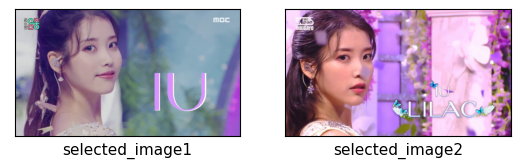

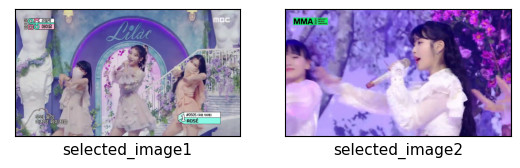

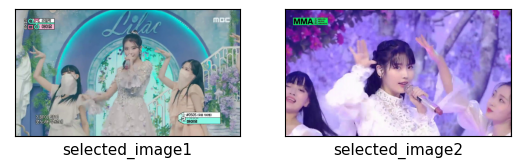

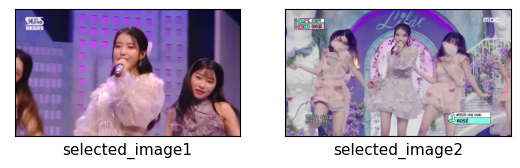

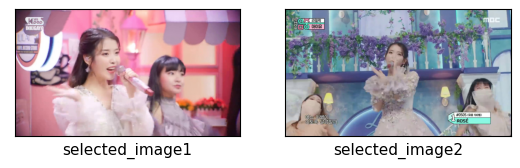

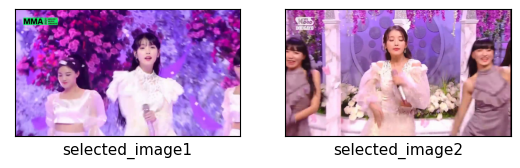

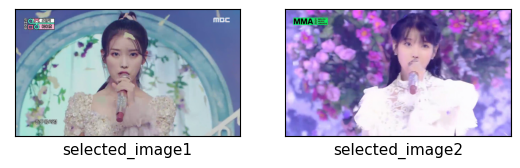

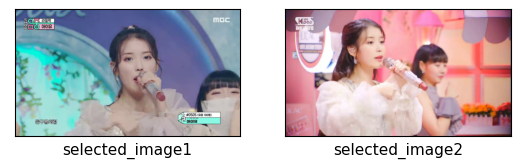

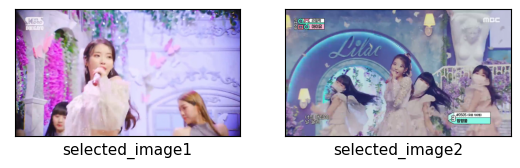

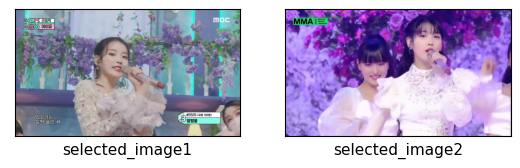

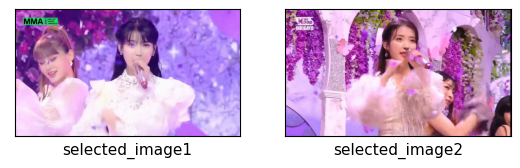

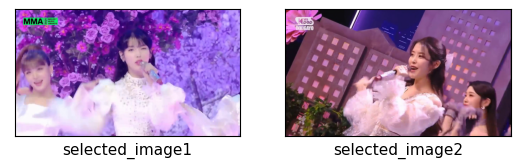

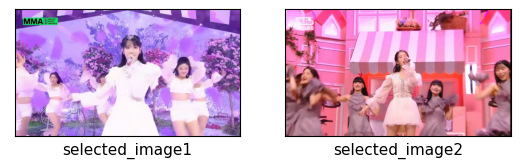

In [53]:
n = 0
video_name = 'iu_lilac'

for frame, selected_video, _ in similarity_list:
    xlabels = ['selected_image1', 'selected_image2']
    
    fig = plt.figure()
    i = 1
    
    if n > 5 : break
    selected_video_num1 = selected_video[0]
    selected_video_num2 = selected_video[1]
    
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(Image.open(f'./dataset/{video_name}/frame/{frame}/{selected_video_num1}.jpg'))
    ax.set_xlabel(xlabels[0])
    ax.set_xticks([]), ax.set_yticks([])
    
    ax = fig.add_subplot(1, 2, i+1)
    ax.imshow(Image.open(f'./dataset/{video_name}/frame/{frame}/{selected_video_num2}.jpg'))
    ax.set_xlabel(xlabels[1])
    ax.set_xticks([]), ax.set_yticks([])
    fig.show()